# **Data Preparation**

### Packages installation

In [25]:
!pip install kagglehub
!pip install imagehash
!pip install tensorflow
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install tqdm

### imports

In [26]:
import sys
import os
import kagglehub
import random
from PIL import Image
import imagehash
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tqdm import tqdm 

### Dataset path

In [27]:
if 'google.colab' in sys.modules:
    dataset_folder = kagglehub.dataset_download('hussainghoraba/emotions-dataset')
    DATASET_PATH = os.path.join(dataset_folder, 'Dataset')
elif 'vscode' in sys.modules:
    DATASET_PATH = './Dataset'
else:
    raise Exception('Unknown environment')

### Set random seed for reproducibility

In [28]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

### Load dataset into memory without dups, and with correct size

Total images in dataset: 2125


Loading images into memory...: 100%|██████████| 2125/2125 [00:27<00:00, 78.14it/s]


Duplicate images found: ./Dataset/Angry/ANGRY_03_0122.png and ./Dataset/Angry/A_5_0092.png


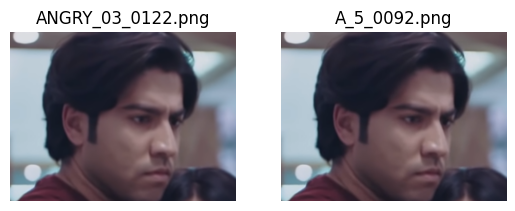

Duplicate images found: ./Dataset/Angry/ANGRY_02_0058.png and ./Dataset/Angry/ANGRY_02_0027.png


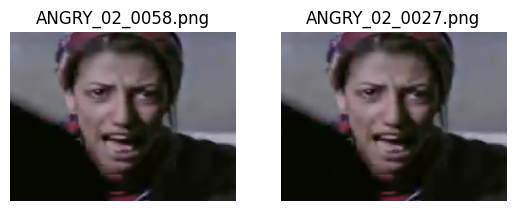

done loading images


In [59]:
total_images_count = sum(len(files) for _, _, files in os.walk(DATASET_PATH))
print(f"Total images in dataset: {total_images_count}")
data = []
dups_pairs = set()
with tqdm(total=total_images_count, desc="Loading images into memory...") as pbar:
    for subfolder in os.listdir(DATASET_PATH):
        subfolder_path = os.path.join(DATASET_PATH, subfolder)
        subfolder_hashes = {}
        for img_file in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, img_file)
            with Image.open(img_path) as img:
                img = img.convert("RGB").resize((512, 512))
                img_arr = np.array(img)
                img_hash = imagehash.phash(img)
            if img_hash not in subfolder_hashes.keys():
                data.append({"img_path": img_path, "label": subfolder, "img_arr": img_arr})
                # key : hash, value : img_path
                subfolder_hashes[img_hash] = img_path
            else:
                existing_duplicate = subfolder_hashes[img_hash]
                dups_pairs.add((img_path, existing_duplicate))
            pbar.update(1)
        
df = pd.DataFrame(data)

# display dups
for dup_pair in dups_pairs:
    print(f"Duplicate images found: {dup_pair[0]} and {dup_pair[1]}")
    img1 = Image.open(dup_pair[0])
    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.title(os.path.basename(dup_pair[0]))
    plt.axis('off')
    img2 = Image.open(dup_pair[1])
    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.title(os.path.basename(dup_pair[1]))
    plt.axis('off')
    plt.show()
print("done loading images")

### Make all classes have the same number of images

In [ ]:
print(f"Before balancing: ")
print(df['label'].value_counts())

min_samples = df['label'].value_counts().min()
df = df.groupby('label', group_keys=False)[df.columns].apply(lambda x: x.sample(n=min_samples, random_state=RANDOM_SEED)).reset_index(drop=True)


print(f"\nAfter balancing: ")
print(df['label'].value_counts())

Before balancing: 
label
Angry      652
Happy      619
Sad        555
Neutral    297
Name: count, dtype: int64

After balancing: 
label
Angry      297
Happy      297
Neutral    297
Sad        297
Name: count, dtype: int64


### Train/Test/Val split

In [61]:
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

train_df, temp_df = train_test_split(df, test_size=(1 - train_ratio), stratify=df['label'], random_state=RANDOM_SEED)
val_df, test_df = train_test_split(temp_df, test_size=(test_ratio / (test_ratio + val_ratio)), stratify=temp_df['label'], random_state=RANDOM_SEED)

# Print the sizes of each split
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 831
Validation set size: 238
Test set size: 119


# **Model 1**

# **Model 2**

In [32]:

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(512, 512, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # assuming one-hot encoding for labels
              metrics=['accuracy'])

# Model summary to verify the architecture
model.summary()


/home/hosain/Desktop/DL project/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'num_classes' is not defined

In [ ]:

# Base paths
base_dir = "images_dataset"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

# Hyperparameters
img_size = (512, 512)
batch_size = 16
num_classes = 4 # Adjust based on the number of emotion classes

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# CNN model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='valid', input_shape=(512, 512, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (5, 5), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (7, 7), activation='relu', padding='valid'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='sigmoid'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10  # You can change this as needed
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test accuracy: {test_acc:.2f}")


Found 1483 images belonging to 4 classes.
Found 423 images belonging to 4 classes.
Found 217 images belonging to 4 classes.
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 857s 9s/step - accuracy: 0.2829 - loss: 1.3637 - val_accuracy: 0.3073 - val_loss: 1.3599
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 849s 9s/step - accuracy: 0.2850 - loss: 1.3603 - val_accuracy: 0.3073 - val_loss: 1.3493
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 857s 9s/step - accuracy: 0.2794 - loss: 1.3615 - val_accuracy: 0.3073 - val_loss: 1.3549
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 862s 9s/step - accuracy: 0.3054 - loss: 1.3401 - val_accuracy: 0.2908 - val_loss: 1.3494
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 860s 9s/step - accuracy: 0.3131 - loss: 1.3527 - val_accuracy: 0.3073 - val_loss: 1.3505
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 858s 9s/step - accuracy: 0.3047 - loss: 1.3516 - val_accuracy: 0.3073 - val_loss: 1.3540
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 855s 9s/step - accuracy: 0.2906 - loss: 1.3636 - val_accuracy: 0.2624 - val_

14/14 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step


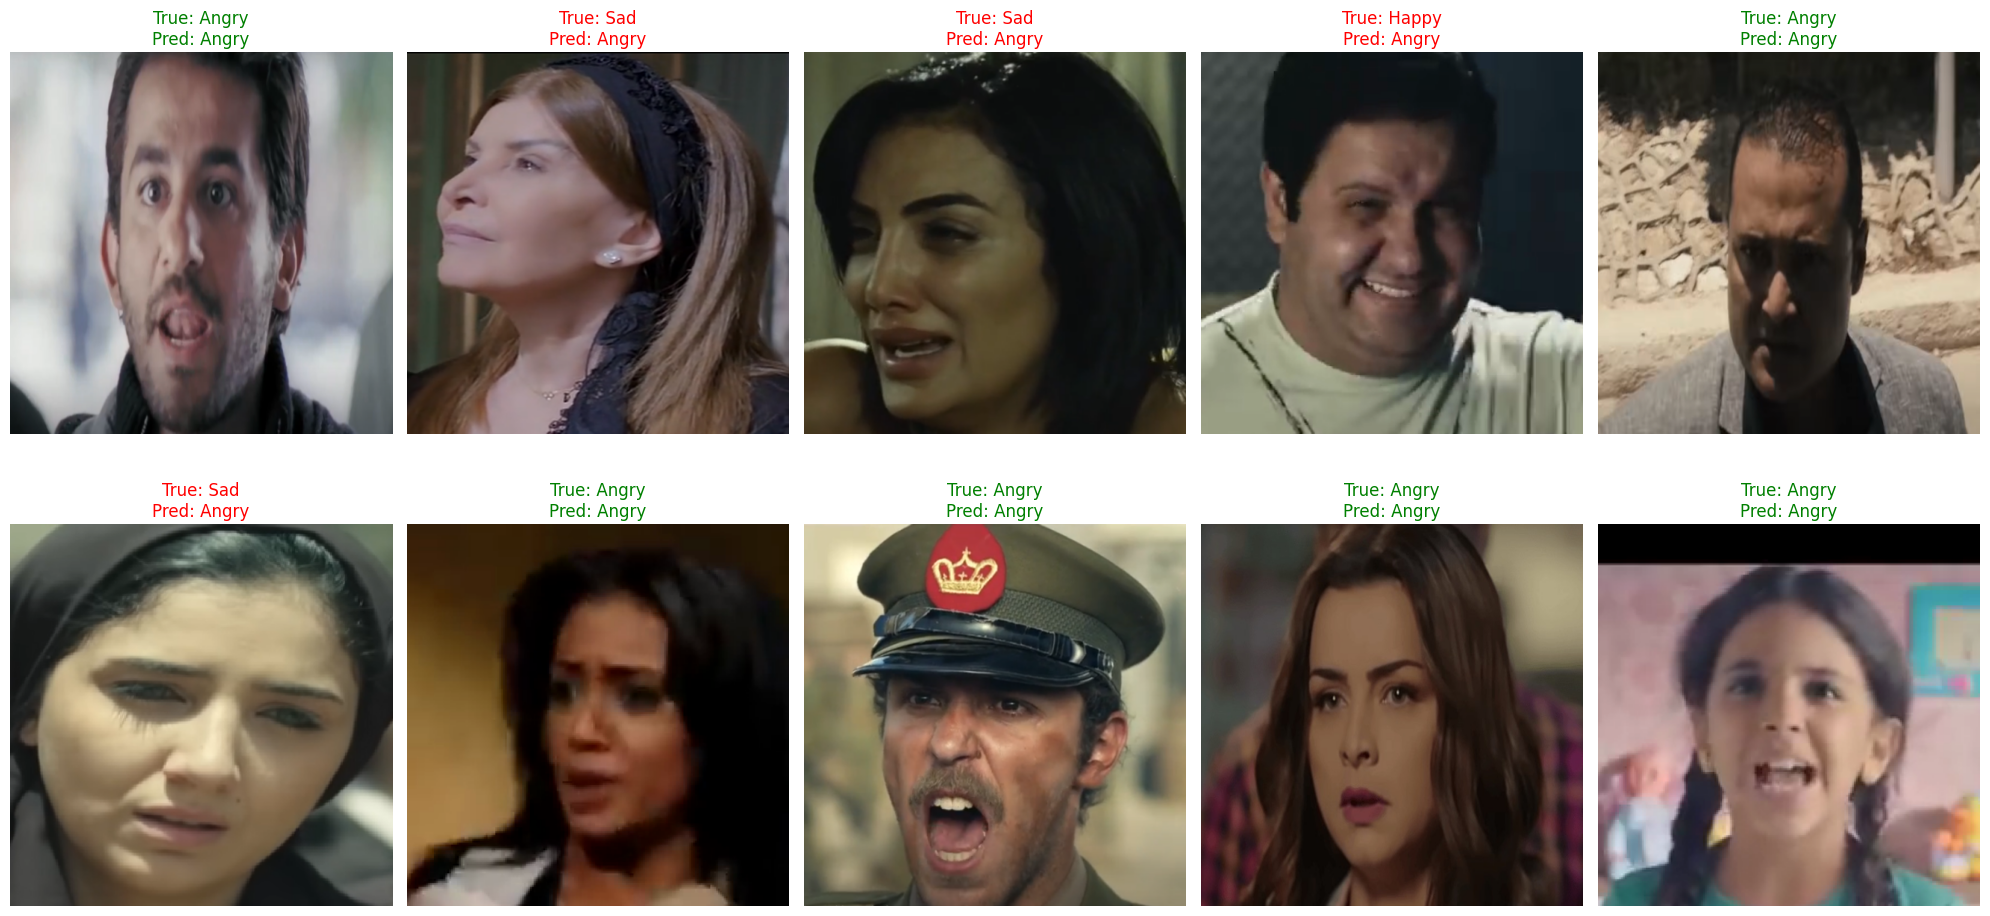

In [ ]:
# Get class indices and reverse mapping
class_indices = test_gen.class_indices
class_labels = list(class_indices.keys())

# Get predictions for the test set
preds = model.predict(test_gen)
predicted_classes = np.argmax(preds, axis=1)
true_classes = test_gen.classes
filenames = test_gen.filenames

# Display 10 random images with predictions
num_images = 10
indices = np.random.choice(len(filenames), num_images, replace=False)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(indices):
    img_path = os.path.join(test_dir, filenames[idx])
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0

    plt.subplot(2, 5, i + 1)
    plt.imshow(img_array)
    plt.axis('off')
    true_label = class_labels[true_classes[idx]]
    predicted_label = class_labels[predicted_classes[idx]]
    title_color = "green" if true_label == predicted_label else "red"
    plt.title(f"True: {true_label}\nPred: {predicted_label}", color=title_color)

plt.tight_layout()
plt.show()
